In [2]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt

# Let's build GoogleNet 


## This architecture uses the Inception module, We will explain this module :)


<h3>Important notes about the first reading : </h3>
<br>
<ul> 
    <li>
        <i>" 1 × 1 convolutions have dual purpose: most critically, they are used mainly as dimension reduction modules to remove computational bottlenecks "</i>
    </li>
    <li>
        <i>The most straightforward way of improving the performance of deep neural networks is by increasing their size</i>
    </li>
    <li>
        <i>Bigger size typically means a larger number of parameters, which makes the enlarged network more
            prone to overfitting</i>
    </li>
    <li>
        <i>Another drawback of uniformly increased network size is the dramatically increased use of computational resources</i>
    </li>
    <li>
        <i> current incarnations of the Inception architecture are restricted to filter sizes 1×1,
3×3 and 5×5, however this decision was based more on convenience rather than necessity</i>
    <li>
        <img src="inception.PNG"/>
    </li>
    <li>
        <i>Besides being used as reductions, they also include the use of rectified linear activation which makes them dual-purpose</i>
    </li>
    <li>
        <i>occasional max-pooling layers with stride 2 to halve the resolution of the grid</i>
    </li>
    <li>
        <img src="GoogleNetSummary.PNG">
    </li>
    <li>
        <i>
            We have also
used a deeper and wider Inception network, the quality of which was slightly inferior, but adding it
to the ensemble seemed to improve the results marginally.
        </i>
    </li>
</ul>

<h2>Topology</h2>

<ul>
    <li><i>size of the receptive field in our network is 224×224 taking RGB color channels with mean subtraction</i></li>
    <li><i>“#3×3 reduce” and “#5×5 reduce” stands for the number of 1×1 filters in the reduction</i></li>
    <li><i>The network is 22 layers deep when counting only layers with
        parameters (or 27 layers if we also count pooling)</i></li>
    <li><i>The overall number of layers (independent building blocks) used for the construction of the network is about 100.</i></li>
    <li><i>however the use of dropout remained
        essential even after removing the fully connected layers</i></li>
    <li><i>By adding auxiliary classifiers connected to
these intermediate layers, we would expect to encourage discrimination in the lower stages in the
classifier, increase the gradient signal that gets propagated back, and provide additional regularization</i></li>
    <li>First extra Classifier : </li>
    <img src="first_classifier.PNG">
    <li>Second extra classifier </li>
    <img src="extra_classifier2.PNG">
    <li><i>An average pooling layer with 5×5 filter size and stride 3, resulting in an 4×4×512 output
        for the (4a), and 4×4×528 for the (4d) stage</i></li>
    <li><i>A 1×1 convolution with 128 filters for dimension reduction and rectified linear activation.</i></li>
    <li><i>A fully connected layer with 1024 units and rectified linear activation.</i></li>
    <li><i>A dropout layer with 70% ratio of dropped outputs</i></li>
    <li><i>A linear layer with softmax loss as the classifier (predicting the same 1000 classes as the
        main classifier, but removed at inference time).</i></li>
    <img src="full_GoogleNet.PNG">
</ul>
<h2>Training </h2>

<ul>
    <li><i> Specifically, we resize the image to 4 scales where the shorter dimension (height or
        width) is 256, 288, 320 and 352 respectively</i></li>
    <li><i>During training, their loss gets added to the total loss of the
network with a discount weight (the losses of the auxiliary classifiers were weighted by 0.3). At
        inference time, these auxiliary networks are discarded.</i></li>

## The Inception block

In [23]:
def inception_block(x,conv1, conv2, conv3, conv4, classifier=False): 
    x1 = tf.keras.layers.Conv2D(filters=conv1[0], kernel_size=1, strides=1, padding="SAME", activation="relu")(x)
    x2 = tf.keras.layers.Conv2D(filters=conv2[0], kernel_size=1, strides=1, padding="SAME", activation="relu")(x)
    x2_b = tf.keras.layers.Conv2D(filters=conv2[1], kernel_size=3, strides=1, padding="SAME", activation="relu")(x)
    x3 = tf.keras.layers.Conv2D(filters=conv3[0], kernel_size=1, strides=1, padding="SAME", activation="relu")(x)
    x3_b = tf.keras.layers.Conv2D(filters=conv3[1], kernel_size=5, strides=1, padding="SAME", activation="relu")(x)
    #Max pooling => 1x1
    max_pool = tf.keras.layers.MaxPooling2D(strides=1, padding="SAME")(x)
    x4 = tf.keras.layers.Conv2D(filters=conv4[0], kernel_size=1, strides=1, padding="SAME", activation="relu")(x)
    #concatenation 
    y = tf.keras.layers.Concatenate(axis=3)([x1,x2_b,x3_b,x4])
    
    if classifier: 
        x5 = tf.keras.layers.AveragePooling2D(pool_size=(5,5),strides=3, padding="VALID")(x, training=True)
        x5_b = tf.keras.layers.Conv2D(filters=128, kernel_size=1, activation="relu")(x5, training=True)
        x5_b_flatten = tf.keras.layers.Flatten()(x5_b, training=True)
        x5_c = tf.keras.layers.Dense(units=1024, activation="relu")(x5_b_flatten, training=True)
        x5_d = tf.keras.layers.Dropout(rate=.7)(x5_c, training=True)
        
        y_pred = tf.keras.layers.Dense(units=1000,activation="softmax")(x5_d, training=True)
        
        return y, y_pred
    return y

#### let's test our inception_block with the first inception topology in the paper (3a). According to the paper, we should have a 28x28x256 output tensor

In [24]:
# we use tf.keras.Input to indicate the input shape
A = tf.keras.Input(shape=(28,28,192))
# We pass our tensor to the inception block
y = inception_block(A, conv1=[64], conv2=[96, 128], conv3=[16,32], conv4=[32])
# We compare our output tensor's dimension to the output tensor's dimension in the paper
y.shape

TensorShape([None, 28, 28, 256])

In [25]:
A = tf.keras.Input(shape=(14,14,512))
y, pred = inception_block(A, conv1=[160], conv2=[112, 224], conv3=[24,64], conv4=[64], classifier=True)
print(pred)
print(pred.shape)

Tensor("dense_39/Identity:0", shape=(None, 1000), dtype=float32)
(None, 1000)


In [32]:
def googleNet(inputs): 
    
    x = inputs
    total_prediction = 0
    
    
    #Stage 1 
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=7, strides=2, padding="SAME")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding="SAME")(x)
    
    x_local_norm = tf.nn.local_response_normalization(x)
    
    #Stage 2 
    
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=1, padding="VALID")(x_local_norm)
    x = tf.keras.layers.Conv2D(filters=192, kernel_size=3, strides=1, padding="SAME")(x)
    x_local_norm = tf.nn.local_response_normalization(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding="SAME")(x_local_norm)
    
    #Stage 3 
    
    #2 inception block 
    filters = [
        [[64], [96,128], [16,32], [32]],
        [[128], [128, 192], [32, 96], [64]]
    ]
        
    for i in range(2): 
        x = inception_block(x,*filters[i])
        
    x = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding="SAME")(x)
    
    #Stage 4
    
    filters = [
        [[192], [96,208], [16, 48], [64]],
        [[160], [112, 223], [24,64], [64]], 
        [[128], [128, 256], [24, 64], [64]], 
        [[112], [144, 288], [32, 64], [64]], 
        [[256], [160, 320], [32, 128], [128]]
        
    ]
    
    for i in range(5): 
        if i == 1 or i == 4: 
            x, aux_pred = inception_block(x, *filters[i], classifier=True)
            total_prediction += 0.3 * aux_pred
        else: 
            x = inception_block(x, *filters[i])
        
    x = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding="SAME")(x)
    
    filters = [
        [[256], [160,320], [32, 128], [128]], 
        [[384], [192,384], [48,128], [128]], 
    ]
    
    for i in range(2): 
        x = inception_block(x, *filters[i])
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(rate=0.4)(x)
    x = tf.keras.layers.Dense(units=1000, activation="relu")(x)
    
    total_prediction += x

    outputs  = tf.keras.layers.Dense(units=1000, activation="sigmoid")(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs), total_prediction

## Let's test the dimensions. Input shape : 224x224x3

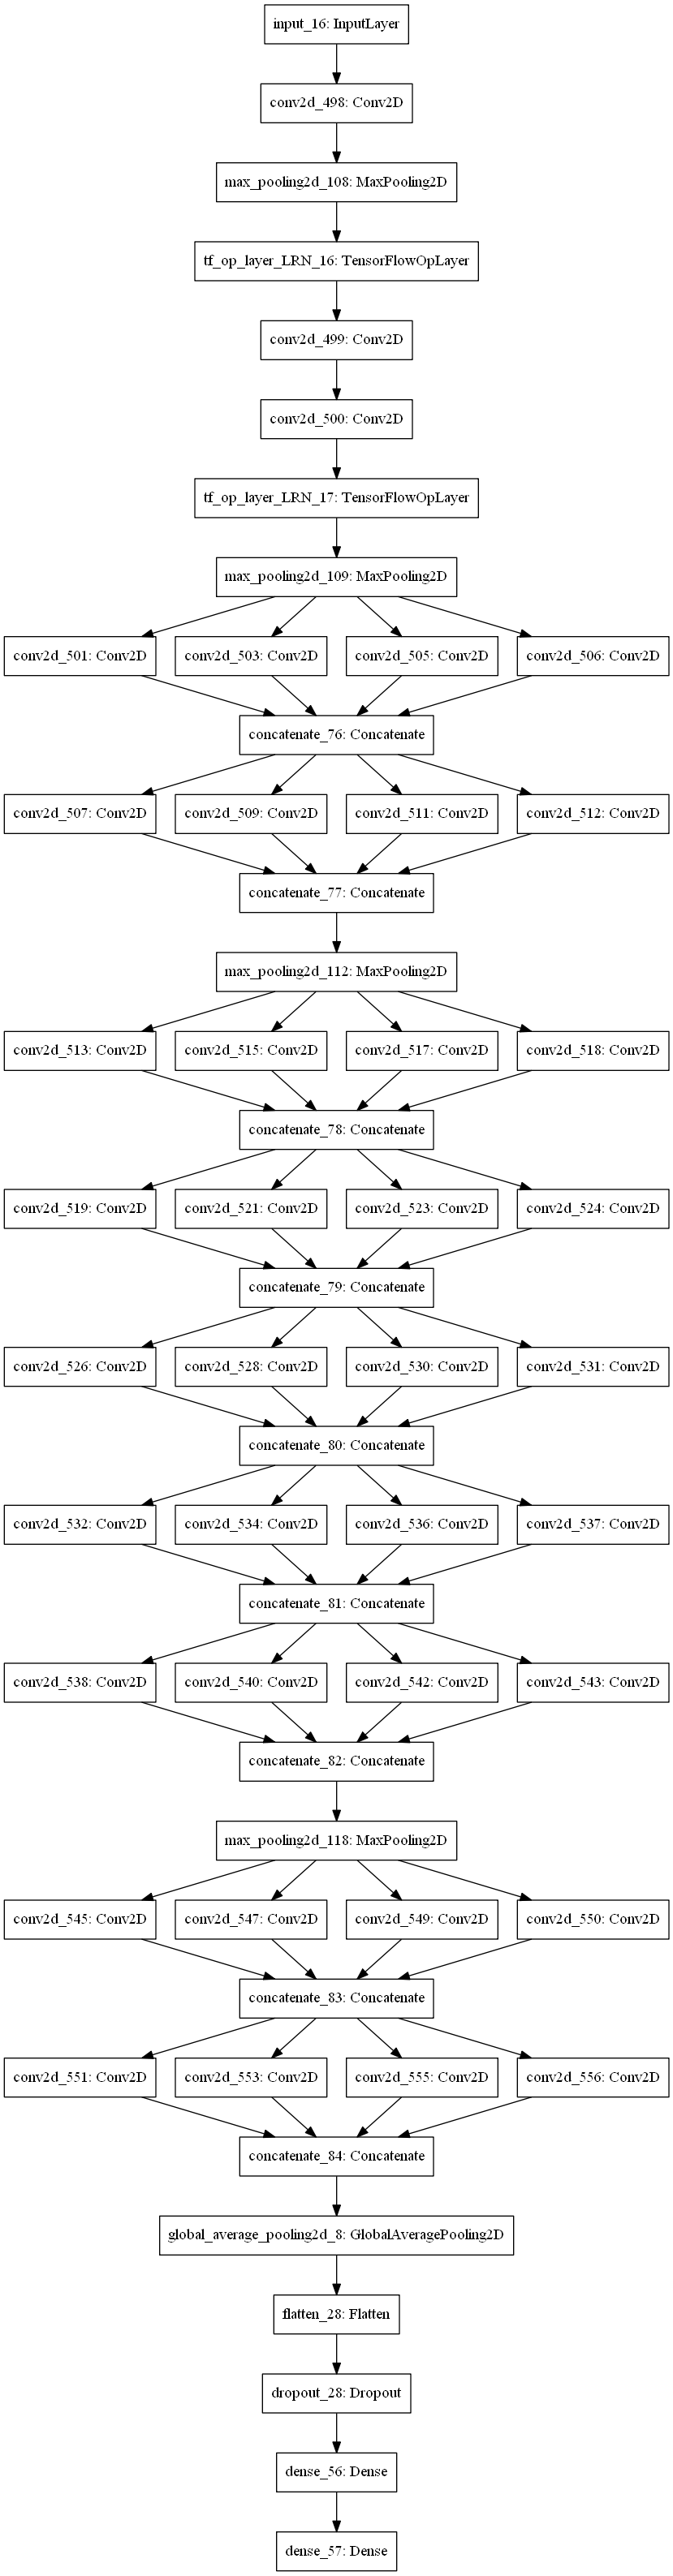

In [33]:
inputs = tf.keras.Input(shape=(224,224,3))
model = googleNet(inputs)[0]
tf.keras.utils.plot_model(model)

In [34]:
print(model.summary())

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_498 (Conv2D)             (None, 112, 112, 64) 9472        input_16[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_108 (MaxPooling2D (None, 56, 56, 64)   0           conv2d_498[0][0]                 
__________________________________________________________________________________________________
tf_op_layer_LRN_16 (TensorFlowO [(None, 56, 56, 64)] 0           max_pooling2d_108[0][0]          
____________________________________________________________________________________________